In [1]:
import sys
import os
import math
import glob
import json

import argparse
import functools

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Polygon, shape, Point, mapping
from shapely.ops import transform
import pyproj

import dask
import dask.dataframe as ddf
from dask.distributed import LocalCluster, Client

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
def get_conf(conf_path):
    with open(conf_path, 'r') as f:
        config = json.load(f)
    return config

In [3]:
def get_area_perimeter_from_lambert(geom):
    '''Area from cell's lambert azimutal projection'''
    perimeter = np.nan
    area = np.nan
    try:
        if (-180 <= geom.centroid.x <= 180) and (-90 <= geom.centroid.y <= 90):
            proj_str = f"+proj=laea +lat_0={geom.centroid.y} +lon_0={geom.centroid.x}"
            project = pyproj.Transformer.from_crs('EPSG:4236', proj_str, always_xy=True).transform
            perimeter = transform(project, geom).length
            area = transform(project, geom).area
        else:
            print(f'invalid centroid {geom.centroid}')
    except Exception as ex:
        print(f'invalid centroid Exception')
        print(ex)
    # return (area, perimeter)
    return pd.Series([area, perimeter])

In [4]:
def zsc_calculation_np(df, spherical=False):
    np_area = df['area'].values
    np_peri = df['perimeter'].values

    if not spherical:
        top = 4*np.pi*np_area
        bottom = np.square(np_peri)
        c_orig = top / bottom

        return c_orig
    else:
        t1 = 4*np.pi*np_area
        t2 = np.square(np_area)
        t3 = np.square(6378137.0)
        top = np.sqrt( t1 - t2/t3 )
        bottom = np_peri
        zsc_np = top / bottom

        # zsc_orig = df.apply(lambda row: math.sqrt(  4*math.pi*row['area'] - math.pow(row['area'],2) / math.pow(6378137,2)  )  /   row['perimeter'], axis=1).values
        # diffs = np.sum(zsc_np - zsc_orig)
        # ma = max_error(zsc_orig, zsc_np)
        # mae = mean_absolute_error(zsc_orig, zsc_np)
        # print(f"ma={ma} mae={mae} diffs={diffs}")

        return zsc_np

In [5]:
def check_crossing(lon1: float, lon2: float, validate: bool = True):
    """
    Assuming a minimum travel distance between two provided longitude coordinates,
    checks if the 180th meridian (antimeridian) is crossed.
    """
    if validate and any(abs(x) > 180.0 for x in [lon1, lon2]):
        raise ValueError("longitudes must be in degrees [-180.0, 180.0]")
    return abs(lon2 - lon1) > 180.0


def check_for_geom(geom):
    crossed = False
    p_init = geom.exterior.coords[0]

    for p in range(1, len(geom.exterior.coords)):
        px = geom.exterior.coords[p]
        # print(px)
        try:
            if check_crossing(p_init[0], px[0]):
                crossed = True
        except ValueError:
            crossed = True

        p_init = px

    return crossed

In [6]:
def check_geom_dfp(gdf):
    gdf['crossed'] = gdf['geometry'].apply(check_for_geom)
    return gdf

In [6]:
results_path = r'R:\kmoch\datacube_data\parquet_src'
config_path = r'..\cell_stats\config.json'
default_name = 'cell_stats'

sample_polygons = gpd.read_file(r'..\cell_stats\sample_polygons.geojson',driver='GeoJSON')

config = get_conf(config_path)

In [7]:
config

{'dggss': [{'name': ['h3'],
   'global_res': [2, 3, 4, 5, 6],
   'sample_res': [7, 8],
   'proj': 'LAEA'},
  {'name': ['s2'],
   'global_res': [2, 4, 5, 6, 7, 8, 9, 10],
   'sample_res': [11, 12],
   'proj': 'LAEA'},
  {'name': ['rhpix'],
   'global_res': [2, 3, 4, 5, 6],
   'sample_res': [7, 8],
   'proj': 'LAEA'},
  {'name': ['DGGRID', 'ISEA7H'],
   'global_res': [2, 3, 4, 5, 6, 7],
   'sample_res': [8, 9],
   'proj': 'LAEA'},
  {'name': ['DGGRID', 'FULLER7H'],
   'global_res': [2, 3, 4, 5, 6, 7],
   'sample_res': [8, 9],
   'proj': 'LAEA'},
  {'name': ['DGGRID', 'ISEA4T'],
   'global_res': [2, 3, 4, 5, 6, 7, 8, 9],
   'sample_res': [10, 11],
   'proj': 'LAEA'},
  {'name': ['DGGRID', 'FULLER4T'],
   'global_res': [2, 3, 4, 5, 6, 7, 8, 9],
   'sample_res': [10, 11],
   'proj': 'LAEA'},
  {'name': ['DGGRID', 'ISEA4D'],
   'global_res': [2, 3, 4, 5, 6, 7, 8, 9, 10],
   'sample_res': [11, 12],
   'proj': 'LAEA'},
  {'name': ['DGGRID', 'FULLER4D'],
   'global_res': [2, 3, 4, 5, 6, 7, 8, 9

In [8]:
[print( f"{idx}: {name['name']}") for (idx, name) in enumerate(config['dggss'])]

0: ['h3']
1: ['s2']
2: ['rhpix']
3: ['DGGRID', 'ISEA7H']
4: ['DGGRID', 'FULLER7H']
5: ['DGGRID', 'ISEA4T']
6: ['DGGRID', 'FULLER4T']
7: ['DGGRID', 'ISEA4D']
8: ['DGGRID', 'FULLER4D']
9: ['DGGRID', 'ISEA3H']
10: ['DGGRID', 'FULLER3H']
11: ['eaggr', 'ISEA4T']
12: ['eaggr', 'ISEA3H']


[None, None, None, None, None, None, None, None, None, None, None, None, None]

In [10]:
config['dggss'][0]['sample_res'].append(5) # h3_5
config['dggss'][1]['sample_res'].append(7) # s2_7
config['dggss'][2]['sample_res'].append(5) # rhpix_5
config['dggss'][3]['sample_res'].append(6) # DGGRID_ISEA7H_6

In [11]:
config['dggss'][1]['global_res'].append(3) # s2_3

<AxesSubplot:>

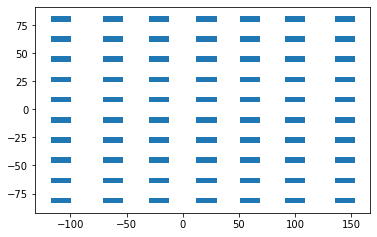

In [9]:
sample_polygons.plot()

In [10]:
counter = 0
found_files = []

for dggs in config['dggss']:
    for res in dggs['global_res']:
        
        params = [dggs['name'], res, dggs['proj'], None]
        d_name, res, p_name = params[0], params[1], params[2]

        name = d_name[0]
        if len(d_name) > 1:
            name = '_'.join(d_name)

        name = f"{name}_{res}_{p_name}"
        parquet_file_name = os.path.join(results_path, f"{name}.parquet")

        if os.path.exists(parquet_file_name):
            # print(f"{parquet_file_name} file exists, ok")
            counter = counter + 1
            found_files.append(parquet_file_name)
        else:
            print(f"{parquet_file_name} file MISSING")
    
    for res in dggs['sample_res']:
        
        params = [dggs['name'], res, dggs['proj'], None]
        d_name, res, p_name = params[0], params[1], params[2]

        for idx, row in sample_polygons.iterrows():
            name = d_name[0]
            if len(d_name) > 1:
                name = '_'.join(d_name)

            name = f"{name}_{res}_{p_name}_sample_id_{idx}"
            parquet_file_name = os.path.join(results_path, f"{name}.parquet")

            if os.path.exists(parquet_file_name):
                # print(f"{parquet_file_name} file exists, ok")
                counter = counter + 1
                found_files.append(parquet_file_name)
            else:
                print(f"{parquet_file_name} file MISSING")


assert(len(set(found_files)) == counter)

import glob

all_parquet = glob.glob(os.path.join(results_path, "*.parquet"))
all_count = len(all_parquet)

print(f"{counter} config based parquet files (vs {all_count}) glob")

diff = set(all_parquet).difference(set(found_files))

1635 config based parquet files (vs 1998) glob


In [14]:
diff

{'D:\\users\\kmoch\\dggs_data\\parquet_src\\h3_2_LAEA_step2.parquet',
 'D:\\users\\kmoch\\dggs_data\\parquet_src\\h3_3_LAEA_step2.parquet',
 'D:\\users\\kmoch\\dggs_data\\parquet_src\\h3_4_LAEA_step2.parquet',
 'D:\\users\\kmoch\\dggs_data\\parquet_src\\h3_5_LAEA_step2.parquet'}

In [15]:
# for each parquet file: do
# take wkt, convert to shapely geom
# take geom, flag crossing
#     da = da.map_partitions( check_geom_dfp, meta=pd.DataFrame({'cell_id':['str'], 'geometry': [ Point(1, 1) ], 'crossed': [True]}))
# get cells area
#     or gdf[['area','perimeter']] = gdf['geometry'].apply(get_area_perimeter_from_lambert)
#     da2 = da2.map_partitions(lambda x: get_cells_area(x, params[2]), meta=pd.DataFrame({'cell_id':['str'], 'geometry': [ Point(1, 1) ], 'crossed': [True], 'area': [1.0],'perimeter': [0.1]}))
# do zsc_calculation_np, shperical and planar
#     da5['c_orig'] = da5.map_partitions(lambda x: zsc_calculation_np(x, False),meta=pd.Series({'c_orig': [0.1]}))
#     da5['zsc'] = da5.map_partitions(lambda x: zsc_calculation_np(x, True), meta=pd.Series({'c_orig': [0.1]}))
# compute centroid, convert to wkt_point
# compute and save to parquet point stats

In [31]:
dclient.close()
cluster.close()

In [17]:
164 / 8

20.5

In [18]:
cpus = 8

cluster = LocalCluster(processes=True, n_workers=cpus)
dclient = Client(cluster)

chunksize = 2000
npartitions = cpus * 20

In [75]:
def the_job(parquet_file_name, parquet_file_name_step2, chunksize, npartitions):
    
    # da = ddf.read_parquet(parquet_file_name, chunksize=chunksize).repartition(npartitions=npartitions)
    da = ddf.read_parquet(parquet_file_name, chunksize=chunksize).repartition(npartitions=npartitions)
    
    da['geometry'] = da.map_partitions( lambda df: df['wkt'].apply(lambda s: wkt.loads(s) if not s == "error" else None), meta=pd.Series({'geometry': [ Point(1, 1) ]}))
    
    da = da.dropna(subset=['geometry'])

    da['crossed'] = da.map_partitions( lambda df: df['geometry'].apply(check_for_geom), meta=pd.Series({'crossed': [True]}))
    # da = da.map_partitions( check_geom_dfp, meta=pd.DataFrame({'cell_id':['str'], 'geometry': [ Point(1, 1) ], 'crossed': [True]}))
    
    # date_line_cross_error_cells = len(da[da['crossed']].compute().index)
    # da2 = da[~da['crossed']]

    result = da.map_partitions(lambda df: df['geometry'].apply(get_area_perimeter_from_lambert), meta=pd.DataFrame({0: [1.0], 1: [0.1]}))
    result = result.rename(columns={0: 'area', 1: 'perimeter'})
    da = da.assign(area=result['area'], perimeter=result['perimeter'] )
    
    # result = result.rename(columns={0: 'upd_siffer', 1: 'upd_siffer_info'})
    # ddf = ddf.assign(upd_siffer=result['upd_siffer'], upd_siffer_info=result['upd_siffer_info'])
    
    # da = da.map_partitions(lambda x: get_cells_area(x, params[2]), meta=pd.DataFrame({'cell_id':['str'], 'geometry': [ Point(1, 1) ], 'crossed': [True], 'area': [1.0],'perimeter': [0.1]}))
    # da4 = da2.persist()

    # area_q_low = da4['area'].quantile(0.005).compute()
    # area_q_high = da4['area'].quantile(0.995).compute()

    # other_geom_anomalies = len( da4[(da4['area'] < area_q_low) & (da4['area'] > area_q_high)] )

    # da4 = da4[(da4['area'] > area_q_low) & (da4['area'] < area_q_high)]

    # da5 = da4.persist()

    da['c_orig'] = da.map_partitions(lambda df: zsc_calculation_np(df, False),meta=pd.Series({'c_orig': [0.1]}))
    da['zsc'] = da.map_partitions(lambda df: zsc_calculation_np(df, True), meta=pd.Series({'zsc': [0.1]}))

    # da6 = da5.persist()
    # da['point_wkt'] = da['geometry'].apply(lambda x: x.wkt, meta=pd.Series({'point_wkt': ['str']}) )
    
    # result = da[~da['area'].isna()]['geometry'].apply(lambda g: pd.Series((g.centroid.x, g.centroid.y)))
    da = da[~da['area'].isna()]
    
    result = da.map_partitions(lambda df: df['geometry'].apply(lambda g: pd.Series((g.centroid.x, g.centroid.y))), meta=pd.DataFrame({0: [1.0], 1: [0.1]}))
    result = result.rename(columns={0: 'lon', 1: 'lat'})
    da = da.assign(lon=result['lon'], lat=result['lat'] )

    
    da = da.drop(columns=["geometry", 'wkt'])
    # da6_fin = da.compute()

    # conclude
    
    da.to_parquet(parquet_file_name_step2, schema="infer", compression='gzip', write_index=False, compute=True)
    return parquet_file_name_step2


In [ ]:
outfile = the_job('../parquet_src/DGGRID_FULLER3H_5_LAEA.parquet', chunksize, npartitions)

In [75]:
df = pd.read_parquet(outfile)
df.sample(3)

,cell_id,crossed,area,perimeter,c_orig,zsc,lon,lat
831,832,False,212.257G,1.719M,902.959m,950.044m,64.937,4.088
316,317,False,204.138G,1.690M,898.203m,947.546m,-76.348,14.311
999,1000,False,202.880G,1.689M,894.091m,945.376m,21.665,64.179


In [71]:
df.describe()

,area,perimeter,c_orig,zsc,lon,lat
count,2.430k,2.430k,2.430k,2.430k,2.432k,2.432k
mean,382.609G,1.761M,895.997m,945.223m,-2.511,-2.467n
std,8.529T,1.560M,52.769m,43.337m,126.526,39.265
min,119.934G,1.532M,8.911m,94.386m,-2.661k,-128.634
25%,205.206G,1.694M,898.367m,947.630m,-86.268,-30.180
50%,209.529G,1.710M,901.312m,949.178m,-538.210m,-380.460a
75%,214.924G,1.729M,904.053m,950.616m,86.179,30.180
max,420.645T,76.389M,906.878m,952.094m,176.926,128.634


In [54]:
pd.set_eng_float_format(accuracy=3, use_eng_prefix=True)
    
df.describe(percentiles=[0.005, 0.995]) 

,area,perimeter,c_orig,zsc,lon,lat
count,2.430k,2.430k,2.430k,2.430k,2.432k,2.432k
mean,382.609G,1.761M,895.997m,945.223m,-2.511,-2.467n
std,8.529T,1.560M,52.769m,43.337m,126.526,39.265
min,119.934G,1.532M,8.911m,94.386m,-2.661k,-128.634
0.5%,163.119G,1.666M,586.112m,754.208m,-175.460,-82.444
50%,209.529G,1.710M,901.312m,949.178m,-538.210m,-380.460a
99.5%,221.673G,2.161M,906.866m,952.090m,174.522,82.444
max,420.645T,76.389M,906.878m,952.094m,176.926,128.634


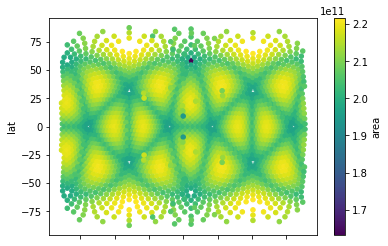

In [67]:
ax = df.plot.scatter(x='lon', y='lat', c='area', colormap='viridis')

In [57]:
df = df[(df['area']>df['area'].quantile(0.005))&(df['area']<df['area'].quantile(0.995))]

<AxesSubplot:xlabel='lon', ylabel='lat'>

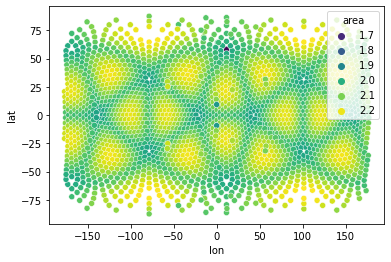

In [65]:
sns.scatterplot(data=df, x="lon", y="lat", hue="area", palette='viridis')

In [ ]:
quick_stats = []

for parquet_file_name in tqdm(found_files):
    
    da = pd.read_parquet(parquet_file_name)
    rows = len(da.index)
    size = os.stat(parquet_file_name).st_size
    # print(f"{parquet_file_name} {rows}")
    quick_stats.append( (parquet_file_name.replace('D:\\users\\kmoch\\dggs_data\\parquet_src\\', ''), rows, size) )


In [20]:
qs = pd.DataFrame(quick_stats, columns=['filename', 'num_rows', 'filesize'])

qs.sort_values(by='filename').to_csv('D:\\users\\kmoch\\dggs_data\\parquet_src\\quick_stats.csv', index=False)

,filename,num_rows,filesize
4,h3_6_LAEA.parquet,14117882,1604716105
654,DGGRID_ISEA7H_7_LAEA.parquet,8235432,916266706
870,DGGRID_FULLER7H_7_LAEA.parquet,8235432,915882657
1315,DGGRID_ISEA4D_10_LAEA.parquet,10485760,485101871
1464,DGGRID_FULLER4D_10_LAEA.parquet,10485760,484577928
98,h3_8_LAEA_sample_id_23.parquet,2083714,231891925
3,h3_5_LAEA.parquet,2016842,229156730
127,h3_8_LAEA_sample_id_52.parquet,1815805,201611538
139,h3_8_LAEA_sample_id_64.parquet,1685948,184292337
118,h3_8_LAEA_sample_id_43.parquet,1632772,183269331


In [20]:
qs = pd.read_csv('D:\\users\\kmoch\\dggs_data\\parquet_src\\quick_stats.csv')

qs.sort_values(by=['filesize', 'num_rows'], ascending=False).head(20)

,filename,num_rows,filesize
1341,h3_6_LAEA.parquet,14117882,1604716105
1113,DGGRID_ISEA7H_7_LAEA.parquet,8235432,916266706
451,DGGRID_FULLER7H_7_LAEA.parquet,8235432,915882657
741,DGGRID_ISEA4D_10_LAEA.parquet,10485760,485101871
149,DGGRID_FULLER4D_10_LAEA.parquet,10485760,484577928
1428,h3_8_LAEA_sample_id_23.parquet,2083714,231891925
1270,h3_5_LAEA.parquet,2016842,229156730
1460,h3_8_LAEA_sample_id_52.parquet,1815805,201611538
1473,h3_8_LAEA_sample_id_64.parquet,1685948,184292337
1450,h3_8_LAEA_sample_id_43.parquet,1632772,183269331


In [76]:
counter = 0
outfiles_files = []

for parquet_file_name in tqdm(found_files):
    
    s = parquet_file_name.replace('D:\\users\\kmoch\\dggs_data\\parquet_src\\', '')
    r = qs.loc[qs['filename'] == s].iloc[0]
    
    parquet_file_name_step2 = f"{parquet_file_name.replace('.parquet', '_step2.parquet')}"
    print(f"{parquet_file_name} checking (rows {r['num_rows']}, size {int(r['filesize']/1024)} KB)")
    if os.path.exists(parquet_file_name_step2):
        print(f"{parquet_file_name_step2} path exists, skip to next")
        outfiles_files.append(parquet_file_name_step2)
    elif r['num_rows'] > 1000000:
        print(f"{parquet_file_name} currently too big, skip to next")
    elif 'sample_id' in parquet_file_name:
        print(f"{parquet_file_name} samples not considered yet, skip to next")
    else:
        outfile = the_job(parquet_file_name, parquet_file_name_step2, chunksize, npartitions=npartitions)
        outfiles_files.append(outfile)


  6%|████▍                                                                        | 110/1916 [00:00<00:01, 1097.70it/s]

D:\users\kmoch\dggs_data\parquet_src\h3_2_LAEA.parquet checking (rows 5882, size 402 KB)
D:\users\kmoch\dggs_data\parquet_src\h3_2_LAEA_step2.parquet path exists, skip to next
D:\users\kmoch\dggs_data\parquet_src\h3_3_LAEA.parquet checking (rows 41162, size 3264 KB)
D:\users\kmoch\dggs_data\parquet_src\h3_3_LAEA_step2.parquet path exists, skip to next
D:\users\kmoch\dggs_data\parquet_src\h3_4_LAEA.parquet checking (rows 288122, size 30392 KB)
D:\users\kmoch\dggs_data\parquet_src\h3_4_LAEA_step2.parquet path exists, skip to next
D:\users\kmoch\dggs_data\parquet_src\h3_5_LAEA.parquet checking (rows 2016842, size 223785 KB)
D:\users\kmoch\dggs_data\parquet_src\h3_5_LAEA_step2.parquet path exists, skip to next
D:\users\kmoch\dggs_data\parquet_src\h3_6_LAEA.parquet checking (rows 14117882, size 1567105 KB)
D:\users\kmoch\dggs_data\parquet_src\h3_6_LAEA.parquet currently too big, skip to next
D:\users\kmoch\dggs_data\parquet_src\h3_7_LAEA_sample_id_0.parquet checking (rows 89427, size 9668 K

 21%|███████████████▊                                                             | 393/1916 [00:00<00:01, 1237.79it/s]


D:\users\kmoch\dggs_data\parquet_src\s2_11_LAEA_sample_id_6.parquet samples not considered yet, skip to next
D:\users\kmoch\dggs_data\parquet_src\s2_11_LAEA_sample_id_7.parquet checking (rows 42595, size 1459 KB)
D:\users\kmoch\dggs_data\parquet_src\s2_11_LAEA_sample_id_7.parquet samples not considered yet, skip to next
D:\users\kmoch\dggs_data\parquet_src\s2_11_LAEA_sample_id_8.parquet checking (rows 20501, size 712 KB)
D:\users\kmoch\dggs_data\parquet_src\s2_11_LAEA_sample_id_8.parquet samples not considered yet, skip to next
D:\users\kmoch\dggs_data\parquet_src\s2_11_LAEA_sample_id_9.parquet checking (rows 8007, size 285 KB)
D:\users\kmoch\dggs_data\parquet_src\s2_11_LAEA_sample_id_9.parquet samples not considered yet, skip to next
D:\users\kmoch\dggs_data\parquet_src\s2_11_LAEA_sample_id_10.parquet checking (rows 24567, size 854 KB)
D:\users\kmoch\dggs_data\parquet_src\s2_11_LAEA_sample_id_10.parquet samples not considered yet, skip to next
D:\users\kmoch\dggs_data\parquet_src\s2_

 36%|███████████████████████████▉                                                 | 694/1916 [00:00<00:00, 1363.55it/s]

D:\users\kmoch\dggs_data\parquet_src\rhpix_7_LAEA_sample_id_54.parquet checking (rows 29924, size 812 KB)
D:\users\kmoch\dggs_data\parquet_src\rhpix_7_LAEA_sample_id_54.parquet samples not considered yet, skip to next
D:\users\kmoch\dggs_data\parquet_src\rhpix_7_LAEA_sample_id_55.parquet checking (rows 29924, size 790 KB)
D:\users\kmoch\dggs_data\parquet_src\rhpix_7_LAEA_sample_id_55.parquet samples not considered yet, skip to next
D:\users\kmoch\dggs_data\parquet_src\rhpix_7_LAEA_sample_id_56.parquet checking (rows 29924, size 774 KB)
D:\users\kmoch\dggs_data\parquet_src\rhpix_7_LAEA_sample_id_56.parquet samples not considered yet, skip to next
D:\users\kmoch\dggs_data\parquet_src\rhpix_7_LAEA_sample_id_57.parquet checking (rows 29926, size 783 KB)
D:\users\kmoch\dggs_data\parquet_src\rhpix_7_LAEA_sample_id_57.parquet samples not considered yet, skip to next
D:\users\kmoch\dggs_data\parquet_src\rhpix_7_LAEA_sample_id_58.parquet checking (rows 29996, size 783 KB)
D:\users\kmoch\dggs_da

 50%|██████████████████████████████████████▌                                      | 960/1916 [00:00<00:00, 1337.66it/s]

D:\users\kmoch\dggs_data\parquet_src\DGGRID_ISEA7H_6_LAEA_sample_id_1.parquet checking (rows 475, size 31 KB)
D:\users\kmoch\dggs_data\parquet_src\DGGRID_ISEA7H_6_LAEA_sample_id_1.parquet samples not considered yet, skip to next
D:\users\kmoch\dggs_data\parquet_src\DGGRID_ISEA7H_6_LAEA_sample_id_2.parquet checking (rows 1897, size 108 KB)
D:\users\kmoch\dggs_data\parquet_src\DGGRID_ISEA7H_6_LAEA_sample_id_2.parquet samples not considered yet, skip to next
D:\users\kmoch\dggs_data\parquet_src\DGGRID_ISEA7H_6_LAEA_sample_id_3.parquet checking (rows 2475, size 140 KB)
D:\users\kmoch\dggs_data\parquet_src\DGGRID_ISEA7H_6_LAEA_sample_id_3.parquet samples not considered yet, skip to next
D:\users\kmoch\dggs_data\parquet_src\DGGRID_ISEA7H_6_LAEA_sample_id_4.parquet checking (rows 2697, size 154 KB)
D:\users\kmoch\dggs_data\parquet_src\DGGRID_ISEA7H_6_LAEA_sample_id_4.parquet samples not considered yet, skip to next
D:\users\kmoch\dggs_data\parquet_src\DGGRID_ISEA7H_6_LAEA_sample_id_5.parquet 

 65%|█████████████████████████████████████████████████▎                          | 1244/1916 [00:00<00:00, 1381.47it/s]

D:\users\kmoch\dggs_data\parquet_src\DGGRID_ISEA4T_10_LAEA_sample_id_17.parquet checking (rows 20284, size 447 KB)
D:\users\kmoch\dggs_data\parquet_src\DGGRID_ISEA4T_10_LAEA_sample_id_17.parquet samples not considered yet, skip to next
D:\users\kmoch\dggs_data\parquet_src\DGGRID_ISEA4T_10_LAEA_sample_id_18.parquet checking (rows 7126, size 164 KB)
D:\users\kmoch\dggs_data\parquet_src\DGGRID_ISEA4T_10_LAEA_sample_id_18.parquet samples not considered yet, skip to next
D:\users\kmoch\dggs_data\parquet_src\DGGRID_ISEA4T_10_LAEA_sample_id_19.parquet checking (rows 7759, size 177 KB)
D:\users\kmoch\dggs_data\parquet_src\DGGRID_ISEA4T_10_LAEA_sample_id_19.parquet samples not considered yet, skip to next
D:\users\kmoch\dggs_data\parquet_src\DGGRID_ISEA4T_10_LAEA_sample_id_20.parquet checking (rows 21439, size 570 KB)
D:\users\kmoch\dggs_data\parquet_src\DGGRID_ISEA4T_10_LAEA_sample_id_20.parquet samples not considered yet, skip to next
D:\users\kmoch\dggs_data\parquet_src\DGGRID_ISEA4T_10_LAEA

 81%|█████████████████████████████████████████████████████████████▌              | 1552/1916 [00:01<00:00, 1402.29it/s]

D:\users\kmoch\dggs_data\parquet_src\DGGRID_FULLER4T_11_LAEA_sample_id_66.parquet checking (rows 128650, size 3491 KB)
D:\users\kmoch\dggs_data\parquet_src\DGGRID_FULLER4T_11_LAEA_sample_id_66.parquet samples not considered yet, skip to next
D:\users\kmoch\dggs_data\parquet_src\DGGRID_FULLER4T_11_LAEA_sample_id_67.parquet checking (rows 80776, size 2237 KB)
D:\users\kmoch\dggs_data\parquet_src\DGGRID_FULLER4T_11_LAEA_sample_id_67.parquet samples not considered yet, skip to next
D:\users\kmoch\dggs_data\parquet_src\DGGRID_FULLER4T_11_LAEA_sample_id_68.parquet checking (rows 27545, size 680 KB)
D:\users\kmoch\dggs_data\parquet_src\DGGRID_FULLER4T_11_LAEA_sample_id_68.parquet samples not considered yet, skip to next
D:\users\kmoch\dggs_data\parquet_src\DGGRID_FULLER4T_11_LAEA_sample_id_69.parquet checking (rows 29966, size 758 KB)
D:\users\kmoch\dggs_data\parquet_src\DGGRID_FULLER4T_11_LAEA_sample_id_69.parquet samples not considered yet, skip to next
D:\users\kmoch\dggs_data\parquet_src\

 89%|███████████████████████████████████████████████████████████████████▎        | 1696/1916 [00:01<00:00, 1412.42it/s]

D:\users\kmoch\dggs_data\parquet_src\DGGRID_FULLER4D_12_LAEA_sample_id_25.parquet checking (rows 316753, size 14203 KB)
D:\users\kmoch\dggs_data\parquet_src\DGGRID_FULLER4D_12_LAEA_sample_id_25.parquet samples not considered yet, skip to next
D:\users\kmoch\dggs_data\parquet_src\DGGRID_FULLER4D_12_LAEA_sample_id_26.parquet checking (rows 251409, size 11307 KB)
D:\users\kmoch\dggs_data\parquet_src\DGGRID_FULLER4D_12_LAEA_sample_id_26.parquet samples not considered yet, skip to next
D:\users\kmoch\dggs_data\parquet_src\DGGRID_FULLER4D_12_LAEA_sample_id_27.parquet checking (rows 163848, size 7416 KB)
D:\users\kmoch\dggs_data\parquet_src\DGGRID_FULLER4D_12_LAEA_sample_id_27.parquet samples not considered yet, skip to next
D:\users\kmoch\dggs_data\parquet_src\DGGRID_FULLER4D_12_LAEA_sample_id_28.parquet checking (rows 55144, size 2518 KB)
D:\users\kmoch\dggs_data\parquet_src\DGGRID_FULLER4D_12_LAEA_sample_id_28.parquet samples not considered yet, skip to next
D:\users\kmoch\dggs_data\parque

 96%|█████████████████████████████████████████████████████████████████████████▏  | 1846/1916 [00:01<00:00, 1436.63it/s]

D:\users\kmoch\dggs_data\parquet_src\DGGRID_FULLER3H_12_LAEA_sample_id_12.parquet checking (rows 11275, size 611 KB)
D:\users\kmoch\dggs_data\parquet_src\DGGRID_FULLER3H_12_LAEA_sample_id_12.parquet samples not considered yet, skip to next
D:\users\kmoch\dggs_data\parquet_src\DGGRID_FULLER3H_12_LAEA_sample_id_13.parquet checking (rows 11946, size 647 KB)
D:\users\kmoch\dggs_data\parquet_src\DGGRID_FULLER3H_12_LAEA_sample_id_13.parquet samples not considered yet, skip to next
D:\users\kmoch\dggs_data\parquet_src\DGGRID_FULLER3H_12_LAEA_sample_id_14.parquet checking (rows 11929, size 650 KB)
D:\users\kmoch\dggs_data\parquet_src\DGGRID_FULLER3H_12_LAEA_sample_id_14.parquet samples not considered yet, skip to next
D:\users\kmoch\dggs_data\parquet_src\DGGRID_FULLER3H_12_LAEA_sample_id_15.parquet checking (rows 11255, size 617 KB)
D:\users\kmoch\dggs_data\parquet_src\DGGRID_FULLER3H_12_LAEA_sample_id_15.parquet samples not considered yet, skip to next
D:\users\kmoch\dggs_data\parquet_src\DGG

100%|█████████████████████████████████████████████████████████████████████████████▉| 1914/1916 [05:02<00:02,  1.33s/it]

D:\users\kmoch\dggs_data\parquet_src\eaggr_ISEA3H_5_LAEA.parquet checking (rows 335960, size 8786 KB)


100%|██████████████████████████████████████████████████████████████████████████████| 1916/1916 [40:15<00:00,  1.26s/it]

D:\users\kmoch\dggs_data\parquet_src\eaggr_ISEA3H_6_LAEA.parquet checking (rows 2350280, size 68567 KB)
D:\users\kmoch\dggs_data\parquet_src\eaggr_ISEA3H_6_LAEA.parquet currently too big, skip to next


In [39]:
da = pd.read_parquet(r'D:\users\kmoch\dggs_data\parquet_src\eaggr_ISEA3H_4_LAEA.parquet')
da.head(3)

,cell_id,wkt
0,"00040,0",POLYGON ((-137.0583748615945 54.91949856849456...
1,"0004-1,0",POLYGON ((-133.4000090921882 48.21982021507636...
2,"00040,1",POLYGON ((-123.8697736457287 53.70800317466193...


In [41]:
da['geometry'] = da['wkt'].apply(lambda s: wkt.loads(s) if not s == "error" else None)
da.isna().sum()

cell_id     0
wkt         0
geometry    0
dtype: int64

In [42]:
len(da.index)

48020

In [43]:
da = da.dropna(subset=['geometry'])
len(da.index)

48020

In [44]:
da['crossed'] = da['geometry'].apply(check_for_geom)
da.sample(3)

,cell_id,wkt,geometry,crossed
35141,"1404-3,-3",POLYGON ((163.5969870333986 -28.40954348731469...,POLYGON ((163.5969870333986 -28.40954348731469...,False
44983,"1804-7,3","POLYGON ((173.907277583249 -24.87357441885524,...","POLYGON ((173.907277583249 -24.87357441885524,...",True
3044,"0104-8,-3",POLYGON ((-88.26643219332848 -4.17209186562711...,POLYGON ((-88.26643219332848 -4.17209186562711...,False


In [45]:
da.isna().sum()

cell_id     0
wkt         0
geometry    0
crossed     0
dtype: int64

In [46]:
result = da['geometry'].apply(get_area_perimeter_from_lambert)

IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid POINT (-199.4878485483026 -74.5147073344572)


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
No Shapely geometry can be created from null value


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid POINT (-199.4878485483026 -74.5147073344572)
invalid centroid Exception
list index out of range


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
No Shapely geometry can be created from null value


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
No Shapely geometry can be created from null value


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
No Shapely geometry can be created from null value


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
No Shapely geometry can be created from null value


Exception ignored in: <function BaseGeometry.__del__ at 0x000001ED992445E8>
Traceback (most recent call last):
  File "C:\Users\kmoch\.conda\envs\geopy2020\lib\site-packages\shapely\geometry\base.py", line 242, in __del__
    self.empty(val=None)
  File "C:\Users\kmoch\.conda\envs\geopy2020\lib\site-packages\shapely\geometry\base.py", line 227, in empty
    self._lgeos.GEOSGeom_destroy(self.__geom__)
KeyboardInterrupt: 
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
No Shapely geometry can be created from null value


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
No Shapely geometry can be created from null value


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range
invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range
invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range
invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range
invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range
invalid centroid POINT (-105.4249292165154 -90.52946475718237)


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range
invalid centroid POINT (-105.4249292165154 -90.52946475718237)
invalid centroid POINT (-105.4249292165154 -90.52946475718237)
invalid centroid POINT (-105.4249292165154 -90.52946475718237)


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
No Shapely geometry can be created from null value


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
No Shapely geometry can be created from null value


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid POINT (105.4249302422813 -90.52946479165918)


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range
invalid centroid POINT (105.4249302422813 -90.52946479165918)
invalid centroid POINT (105.4249302422813 -90.52946479165918)
invalid centroid POINT (105.4249302422813 -90.52946479165918)
invalid centroid POINT (105.4249302422813 -90.52946479165918)


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
No Shapely geometry can be created from null value


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
No Shapely geometry can be created from null value


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range
invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range
invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers
IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range
invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range


IllegalArgumentException: CGAlgorithmsDD::orientationIndex encountered NaN/Inf numbers


invalid centroid Exception
No Shapely geometry can be created from null value
invalid centroid Exception
list index out of range


In [51]:
result = result.rename(columns={0: 'area', 1: 'perimeter'})

In [55]:
da = da.assign(area=result['area'], perimeter=result['perimeter'] )

In [59]:
da[da['area'].isna()]

,cell_id,wkt,geometry,crossed,area,perimeter
2143,"0004-16,-1",POLYGON ((114.1499923160697 -88.81195566527983...,POLYGON ((114.1499923160697 -88.81195566527983...,True,NaN,NaN
2147,"0004-16,0",POLYGON ((-42.1499923368007 -88.81195566907286...,POLYGON ((-42.1499923368007 -88.81195566907286...,True,NaN,NaN
2150,"0004-16,-4",POLYGON ((66.79648195090192 -78.01110169434224...,POLYGON ((66.79648195090192 -78.01110169434224...,False,NaN,NaN
2154,"0004-16,-3","POLYGON ((81.77018480021809 -82.8165657197694,...","POLYGON ((81.77018480021809 -82.8165657197694,...",False,NaN,NaN
2346,"0004-16,-1",POLYGON ((114.1499923160697 -88.81195566527983...,POLYGON ((114.1499923160697 -88.81195566527983...,True,NaN,NaN
...,...,...,...,...,...,...
47766,"1904-16,0",POLYGON ((-36.90441736577446 27.60671078308536...,POLYGON ((-36.90441736577446 27.60671078308536...,False,NaN,NaN
47769,"1904-16,-4",POLYGON ((-23.08311537979006 30.90010716093234...,POLYGON ((-23.08311537979006 30.90010716093234...,False,NaN,NaN
47773,"1904-16,-3",POLYGON ((-27.93569375522389 27.52992565848242...,POLYGON ((-27.93569375522389 27.52992565848242...,False,NaN,NaN
47965,"1904-16,-1","POLYGON ((-34.7850266362662 26.22288643168209,...","POLYGON ((-34.7850266362662 26.22288643168209,...",False,NaN,NaN


In [60]:
area_q_low = da['area'].quantile(0.005)
area_q_high = da['area'].quantile(0.995)

other_geom_anomalies = len( da[(da['area'] < area_q_low) & (da['area'] > area_q_high)] )

In [61]:
da['c_orig'] = zsc_calculation_np(da, False)
da['zsc'] = zsc_calculation_np(da, True)

In [63]:
da.head(3)

,cell_id,wkt,geometry,crossed,area,perimeter,c_orig,zsc
0,"00040,0",POLYGON ((-137.0583748615945 54.91949856849456...,POLYGON ((-137.0583748615945 54.91949856849456...,False,6.042065e+11,2.915767e+06,0.893079,0.944470
1,"0004-1,0",POLYGON ((-133.4000090921882 48.21982021507636...,POLYGON ((-133.4000090921882 48.21982021507636...,False,6.295028e+11,2.964189e+06,0.900317,0.948266
2,"00040,1",POLYGON ((-123.8697736457287 53.70800317466193...,POLYGON ((-123.8697736457287 53.70800317466193...,False,6.290591e+11,2.963151e+06,0.900314,0.948265


In [67]:
result = da[~da['area'].isna()]['geometry'].apply(lambda g: pd.Series((g.centroid.x, g.centroid.y)))
result = result.rename(columns={0: 'lon', 1: 'lat'})
da = da.assign(lon=result['lon'], lat=result['lat'] )

In [68]:
da[da['area'].isna()]

,cell_id,wkt,geometry,crossed,area,perimeter,c_orig,zsc,lon,lat
2143,"0004-16,-1",POLYGON ((114.1499923160697 -88.81195566527983...,POLYGON ((114.1499923160697 -88.81195566527983...,True,NaN,NaN,NaN,NaN,NaN,NaN
2147,"0004-16,0",POLYGON ((-42.1499923368007 -88.81195566907286...,POLYGON ((-42.1499923368007 -88.81195566907286...,True,NaN,NaN,NaN,NaN,NaN,NaN
2150,"0004-16,-4",POLYGON ((66.79648195090192 -78.01110169434224...,POLYGON ((66.79648195090192 -78.01110169434224...,False,NaN,NaN,NaN,NaN,NaN,NaN
2154,"0004-16,-3","POLYGON ((81.77018480021809 -82.8165657197694,...","POLYGON ((81.77018480021809 -82.8165657197694,...",False,NaN,NaN,NaN,NaN,NaN,NaN
2346,"0004-16,-1",POLYGON ((114.1499923160697 -88.81195566527983...,POLYGON ((114.1499923160697 -88.81195566527983...,True,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
47766,"1904-16,0",POLYGON ((-36.90441736577446 27.60671078308536...,POLYGON ((-36.90441736577446 27.60671078308536...,False,NaN,NaN,NaN,NaN,NaN,NaN
47769,"1904-16,-4",POLYGON ((-23.08311537979006 30.90010716093234...,POLYGON ((-23.08311537979006 30.90010716093234...,False,NaN,NaN,NaN,NaN,NaN,NaN
47773,"1904-16,-3",POLYGON ((-27.93569375522389 27.52992565848242...,POLYGON ((-27.93569375522389 27.52992565848242...,False,NaN,NaN,NaN,NaN,NaN,NaN
47965,"1904-16,-1","POLYGON ((-34.7850266362662 26.22288643168209,...","POLYGON ((-34.7850266362662 26.22288643168209,...",False,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
geometry_errors = da['area'].isna().sum()

In [72]:
print(f"{area_q_low}, {area_q_high}, {other_geom_anomalies}, {geometry_errors}")

604280290583.5791, 632629712781.6162, 0, 131


In [73]:
# da = da[~da['area'].isna()]
# da = da[(da['area'] > area_q_low) & (da['area'] < area_q_high)]

da = da.drop(columns=["geometry", 'wkt'])
da.to_parquet(parquet_file_name_step2, compression='gzip', index=False)

In [74]:
parquet_file_name_step2

'D:\\users\\kmoch\\dggs_data\\parquet_src\\eaggr_ISEA3H_4_LAEA_step2.parquet'

## prep hpc worklist

In [16]:
counter = 0
found_files = []

for dggs in config['dggss']:
    for res in dggs['global_res']:
        
        params = [dggs['name'], res, dggs['proj'], None]
        d_name, res, p_name = params[0], params[1], params[2]

        name = d_name[0]
        if len(d_name) > 1:
            name = '_'.join(d_name)

        name = f"{name}_{res}_{p_name}"
        
        parquet_file_name = f"{name}.parquet"
        test_file_name = os.path.join(results_path, parquet_file_name)

        if os.path.exists(test_file_name):
            # print(f"{parquet_file_name} file exists, ok")
            counter = counter + 1
            found_files.append(parquet_file_name)
        else:
            print(f"{parquet_file_name} file MISSING")
    
    for res in dggs['sample_res']:
        
        params = [dggs['name'], res, dggs['proj'], None]
        d_name, res, p_name = params[0], params[1], params[2]

        for idx, row in sample_polygons.iterrows():
            name = d_name[0]
            if len(d_name) > 1:
                name = '_'.join(d_name)

            name = f"{name}_{res}_{p_name}_sample_id_{idx}"
            parquet_file_name = f"{name}.parquet"
            test_file_name = os.path.join(results_path, parquet_file_name)

            if os.path.exists(test_file_name):
                # print(f"{parquet_file_name} file exists, ok")
                counter = counter + 1
                found_files.append(parquet_file_name)
            else:
                print(f"{parquet_file_name} file MISSING")


assert(len(set(found_files)) == counter)

In [18]:
worklist = []

for parquet_file_name in tqdm(found_files):
    
    parquet_file_name_step2 = f"{parquet_file_name.replace('.parquet', '_step2.parquet')}"
    
    test_file_name = os.path.join(results_path, parquet_file_name_step2)
    
    if os.path.exists(test_file_name):
        print(f"{parquet_file_name_step2} path exists, skip to next")
        
    else:
        outfile = (parquet_file_name, parquet_file_name_step2)
        worklist.append(outfile)

  7%|██████████████████▌                                                                                                                                                                                                                                                                 | 110/1635 [00:00<00:03, 499.89it/s]

h3_2_LAEA_step2.parquet path exists, skip to next
h3_3_LAEA_step2.parquet path exists, skip to next
h3_4_LAEA_step2.parquet path exists, skip to next
h3_5_LAEA_step2.parquet path exists, skip to next
h3_7_LAEA_sample_id_0_step2.parquet path exists, skip to next
h3_7_LAEA_sample_id_1_step2.parquet path exists, skip to next
h3_7_LAEA_sample_id_2_step2.parquet path exists, skip to next
h3_7_LAEA_sample_id_3_step2.parquet path exists, skip to next
h3_7_LAEA_sample_id_4_step2.parquet path exists, skip to next


 14%|████████████████████████████████████████                                                                                                                                                                                                                                            | 237/1635 [00:00<00:02, 559.39it/s]

s2_2_LAEA_step2.parquet path exists, skip to next
s2_4_LAEA_step2.parquet path exists, skip to next
s2_5_LAEA_step2.parquet path exists, skip to next
s2_6_LAEA_step2.parquet path exists, skip to next
s2_7_LAEA_step2.parquet path exists, skip to next
s2_8_LAEA_step2.parquet path exists, skip to next


 23%|███████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                    | 379/1635 [00:00<00:02, 626.64it/s]

rhpix_2_LAEA_step2.parquet path exists, skip to next
rhpix_3_LAEA_step2.parquet path exists, skip to next
rhpix_4_LAEA_step2.parquet path exists, skip to next
rhpix_5_LAEA_step2.parquet path exists, skip to next
DGGRID_ISEA7H_2_LAEA_step2.parquet path exists, skip to next


 31%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                               | 502/1635 [00:00<00:01, 601.37it/s]

DGGRID_ISEA7H_3_LAEA_step2.parquet path exists, skip to next
DGGRID_ISEA7H_4_LAEA_step2.parquet path exists, skip to next
DGGRID_ISEA7H_5_LAEA_step2.parquet path exists, skip to next


 43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                             | 702/1635 [00:01<00:01, 641.08it/s]

DGGRID_FULLER7H_2_LAEA_step2.parquet path exists, skip to next
DGGRID_FULLER7H_3_LAEA_step2.parquet path exists, skip to next
DGGRID_FULLER7H_4_LAEA_step2.parquet path exists, skip to next
DGGRID_FULLER7H_5_LAEA_step2.parquet path exists, skip to next


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 844/1635 [00:01<00:01, 673.20it/s]

DGGRID_ISEA4T_2_LAEA_step2.parquet path exists, skip to next
DGGRID_ISEA4T_3_LAEA_step2.parquet path exists, skip to next
DGGRID_ISEA4T_4_LAEA_step2.parquet path exists, skip to next
DGGRID_ISEA4T_5_LAEA_step2.parquet path exists, skip to next
DGGRID_ISEA4T_6_LAEA_step2.parquet path exists, skip to next
DGGRID_ISEA4T_7_LAEA_step2.parquet path exists, skip to next
DGGRID_FULLER4T_2_LAEA_step2.parquet path exists, skip to next


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 979/1635 [00:01<00:01, 640.21it/s]

DGGRID_FULLER4T_3_LAEA_step2.parquet path exists, skip to next
DGGRID_FULLER4T_4_LAEA_step2.parquet path exists, skip to next
DGGRID_FULLER4T_5_LAEA_step2.parquet path exists, skip to next
DGGRID_FULLER4T_6_LAEA_step2.parquet path exists, skip to next
DGGRID_FULLER4T_7_LAEA_step2.parquet path exists, skip to next


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 1108/1635 [00:01<00:00, 618.38it/s]

DGGRID_ISEA4D_2_LAEA_step2.parquet path exists, skip to next
DGGRID_ISEA4D_3_LAEA_step2.parquet path exists, skip to next
DGGRID_ISEA4D_4_LAEA_step2.parquet path exists, skip to next
DGGRID_ISEA4D_5_LAEA_step2.parquet path exists, skip to next
DGGRID_ISEA4D_6_LAEA_step2.parquet path exists, skip to next
DGGRID_ISEA4D_7_LAEA_step2.parquet path exists, skip to next
DGGRID_ISEA4D_8_LAEA_step2.parquet path exists, skip to next


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1315/1635 [00:02<00:00, 667.47it/s]

DGGRID_FULLER4D_2_LAEA_step2.parquet path exists, skip to next
DGGRID_FULLER4D_3_LAEA_step2.parquet path exists, skip to next
DGGRID_FULLER4D_4_LAEA_step2.parquet path exists, skip to next
DGGRID_FULLER4D_5_LAEA_step2.parquet path exists, skip to next
DGGRID_FULLER4D_6_LAEA_step2.parquet path exists, skip to next
DGGRID_FULLER4D_7_LAEA_step2.parquet path exists, skip to next
DGGRID_FULLER4D_8_LAEA_step2.parquet path exists, skip to next


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 1457/1635 [00:02<00:00, 649.52it/s]

DGGRID_ISEA3H_2_LAEA_step2.parquet path exists, skip to next
DGGRID_ISEA3H_3_LAEA_step2.parquet path exists, skip to next
DGGRID_ISEA3H_4_LAEA_step2.parquet path exists, skip to next
DGGRID_ISEA3H_5_LAEA_step2.parquet path exists, skip to next
DGGRID_ISEA3H_6_LAEA_step2.parquet path exists, skip to next
DGGRID_ISEA3H_7_LAEA_step2.parquet path exists, skip to next
DGGRID_ISEA3H_8_LAEA_step2.parquet path exists, skip to next
DGGRID_ISEA3H_9_LAEA_step2.parquet path exists, skip to next
DGGRID_ISEA3H_10_LAEA_step2.parquet path exists, skip to next


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1596/1635 [00:02<00:00, 655.76it/s]

DGGRID_FULLER3H_2_LAEA_step2.parquet path exists, skip to next
DGGRID_FULLER3H_3_LAEA_step2.parquet path exists, skip to next
DGGRID_FULLER3H_4_LAEA_step2.parquet path exists, skip to next
DGGRID_FULLER3H_5_LAEA_step2.parquet path exists, skip to next
DGGRID_FULLER3H_6_LAEA_step2.parquet path exists, skip to next
DGGRID_FULLER3H_7_LAEA_step2.parquet path exists, skip to next
DGGRID_FULLER3H_8_LAEA_step2.parquet path exists, skip to next
DGGRID_FULLER3H_9_LAEA_step2.parquet path exists, skip to next
DGGRID_FULLER3H_10_LAEA_step2.parquet path exists, skip to next


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1635/1635 [00:02<00:00, 629.85it/s]

eaggr_ISEA4T_2_LAEA_step2.parquet path exists, skip to next
eaggr_ISEA4T_3_LAEA_step2.parquet path exists, skip to next
eaggr_ISEA4T_4_LAEA_step2.parquet path exists, skip to next
eaggr_ISEA4T_5_LAEA_step2.parquet path exists, skip to next
eaggr_ISEA4T_6_LAEA_step2.parquet path exists, skip to next
eaggr_ISEA4T_7_LAEA_step2.parquet path exists, skip to next
eaggr_ISEA3H_2_LAEA_step2.parquet path exists, skip to next
eaggr_ISEA3H_3_LAEA_step2.parquet path exists, skip to next
eaggr_ISEA3H_4_LAEA_step2.parquet path exists, skip to next
eaggr_ISEA3H_5_LAEA_step2.parquet path exists, skip to next


In [19]:
worklist[0]

('h3_6_LAEA.parquet', 'h3_6_LAEA_step2.parquet')

In [20]:
df = pd.DataFrame(worklist, columns=["infile", "outfile"])
df.head(3)

,infile,outfile
0,h3_6_LAEA.parquet,h3_6_LAEA_step2.parquet
1,h3_7_LAEA_sample_id_5.parquet,h3_7_LAEA_sample_id_5_step2.parquet
2,h3_7_LAEA_sample_id_6.parquet,h3_7_LAEA_sample_id_6_step2.parquet


In [22]:
df.to_csv(os.path.join(results_path, "worklist.csv"))

'h3_7_LAEA_sample_id_12.parquet'

In [25]:
pd.read_csv(os.path.join(results_path, "worklist.csv"), index_col=0).head(2)

,infile,outfile
0,h3_6_LAEA.parquet,h3_6_LAEA_step2.parquet
1,h3_7_LAEA_sample_id_5.parquet,h3_7_LAEA_sample_id_5_step2.parquet


In [28]:
os.curdir

'.'